#Only 3 categories (Q1, Q2, Q3)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import h5py, numpy as np, pandas as pd
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import zscore

In [3]:
mat_path = '/content/drive/MyDrive/AIRS/A1_InputData.mat'
survey_path = '/content/drive/MyDrive/AIRS/Survey_result.xlsx'
conditions = ['NF', 'VF', 'HF', 'VFH']

In [4]:
with h5py.File(mat_path, 'r') as f:
    # Explore keys to navigate
    print(list(f.keys()))

['#refs#', 'bpm', 'ecg', 'eda', 'ee_pos', 'eeg', 'emg', 'fs', 'tar_count', 'tar_pos', 'tar_string', 'tr_time']


In [5]:
with h5py.File(mat_path, 'r') as f:
    eeg_group = f['eeg']
    print("Keys inside 'eeg':", list(eeg_group.keys()))

Keys inside 'eeg': ['subj']


In [6]:
with h5py.File(mat_path, 'r') as f:
    subj_dataset = f['eeg']['subj']
    print("EEG dataset type:", type(subj_dataset))
    print("EEG dataset shape:", subj_dataset.shape)
    print("EEG dataset dtype:", subj_dataset.dtype)

EEG dataset type: <class 'h5py._hl.dataset.Dataset'>
EEG dataset shape: (20, 1)
EEG dataset dtype: object


the 20 subjects

In [7]:
with h5py.File(mat_path, 'r') as f:
    # reference to the first subject's data (index 0)
    subj_ref = f['eeg']['subj'][0][0]
    # derefernce sub
    subj_data = f[subj_ref]
    print("Keys inside subject 0 EEG data:", list(subj_data.keys()))

Keys inside subject 0 EEG data: ['cond']


assuming 4 conditions

In [8]:
with h5py.File(mat_path, 'r') as f:
    subj_ref = f['eeg']['subj'][0][0]
    subj_data = f[subj_ref]


    cond_group = subj_data['cond']
    print("Number of conditions:", len(cond_group))

Number of conditions: 4


In [9]:
with h5py.File(mat_path, 'r') as f:
    subj_ref = f['eeg']['subj'][0][0]
    subj_data = f[subj_ref]


    cond_refs = subj_data['cond']
    print("Condition refs shape:", cond_refs.shape)


    cond1_ref = cond_refs[0][0]
    cond1_data = f[cond1_ref]
    print("Keys inside cond1:", list(cond1_data.keys()))

Condition refs shape: (4, 1)
Keys inside cond1: ['block']


In [10]:
with h5py.File(mat_path, 'r') as f:
    subj_ref = f['eeg']['subj'][0][0]
    subj_data = f[subj_ref]

    cond_refs = subj_data['cond']
    cond1_ref = cond_refs[0][0]
    cond1_data = f[cond1_ref]

    block_refs = cond1_data['block']
    print("Block refs shape:", block_refs.shape)


    pre_block_ref = block_refs[0][0]
    pre_block_data = f[pre_block_ref]
    print("Keys inside pre block:", list(pre_block_data.keys()))

Block refs shape: (3, 1)
Keys inside pre block: ['trial']


In [11]:

with h5py.File(mat_path, 'r') as f:
    subj = f[f['eeg']['subj'][0][0]]
    cond = f[subj['cond'][0][0]]
    block = f[cond['block'][0][0]]
    trial_ref = block['trial'][0][0]

    trial_obj = f[trial_ref]
    print(f"Trial Object Type: {type(trial_obj)}")

    if isinstance(trial_obj, h5py.Group):
        print("Keys in this trial:")
        for key in trial_obj.keys():
            item = trial_obj[key]
            if isinstance(item, h5py.Dataset):
                print(f" - {key}: shape={item.shape}, dtype={item.dtype}")
            elif isinstance(item, h5py.Group):
                print(f" - {key}: [Group]")
            else:
                print(f" - {key}: Unknown type: {type(item)}")
    elif isinstance(trial_obj, h5py.Dataset):
        print("It's a dataset with shape:", trial_obj.shape)
        print("Sample values (first 5):", trial_obj[:5])
    else:
        print("Not a group or dataset. Type:", type(trial_obj))

Trial Object Type: <class 'h5py._hl.dataset.Dataset'>
It's a dataset with shape: (64, 2101)
Sample values (first 5): [[ 13.841225    14.613592    19.685474   ... -18.737572   -24.565025
  -25.008516  ]
 [ -2.9647427   -1.7198955    2.550235   ...   1.3416407   -5.293282
   -2.4807878 ]
 [  5.647258     7.4309564    5.3324914  ...  17.721712     7.6665425
    1.7839926 ]
 [ 15.332928    12.758159    13.786263   ... -64.510994   -70.421455
  -74.498146  ]
 [ 12.893918    15.290134    18.90179    ...   4.0063725   -0.65261096
   -4.5601745 ]]


so this means: - single block of data as datset; 64 EEG rows with 2101 time-points

In [ ]:
def compute_bandpowers(signal, sf=256):
    freqs, psd = welch(signal, sf, nperseg=sf*2)
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 12),
        'beta': (12, 30),
        'gamma': (30, 45),
    }
    bandpowers = {}
    for band, (low, high) in bands.items():
        idx = np.logical_and(freqs >= low, freqs <= high)
        bandpowers[band] = np.trapz(psd[idx], freqs[idx])
    return bandpowers

In [ ]:
import pandas as pd
from scipy.signal import welch

features_list = []

with h5py.File(mat_path, 'r') as f:
    subj_group = f['eeg']['subj']

    for s in range(subj_group.shape[0]):
        subj_ref = subj_group[s][0]
        subj = f[subj_ref]
        cond_group = subj['cond']

        for c in range(cond_group.shape[0]):
            cond_ref = cond_group[c][0]
            cond = f[cond_ref]
            block_group = cond['block']

            # Only use training block (index=1)
            block_ref = block_group[1][0]
            block = f[block_ref]
            trial_group = block['trial']

            for t in range(trial_group.shape[0]):
                trial_ref = trial_group[t][0]
                trial = f[trial_ref][()]

                # trial shape: (64, N), transpose
                trial = trial.T  # (N, 64)

                trial_feats = {}
                for ch in range(trial.shape[1]):
                    bp = compute_bandpowers(trial[:, ch])
                    for band in bp:
                        trial_feats[f'ch{ch}_{band}'] = bp[band]

                trial_feats['Subject'] = s + 1
                trial_feats['Condition'] = c + 1
                trial_feats['Trial'] = t + 1
                features_list.append(trial_feats)

# Convert to DataFrame
df_eeg = pd.DataFrame(features_list)
print(df_eeg.head())

/tmp/ipython-input-10-4177768076.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bandpowers[band] = np.trapz(psd[idx], freqs[idx])


   ch0_delta  ch0_theta  ch0_alpha   ch0_beta  ch0_gamma  ch1_delta  \
0  58.579982   9.832955   3.353836  11.649046  10.161449  43.510715   
1  46.378695   8.339626   3.538782   9.046374  10.394174  37.365714   
2  32.812305   7.578251   3.699016  11.989093   9.863100  23.379916   
3  34.071491   7.868513   3.434858   9.397843   9.426767  28.030302   
4  39.920032   9.036787   4.326548   9.555223   9.015601  31.026725   

   ch1_theta  ch1_alpha   ch1_beta  ch1_gamma  ...  ch62_beta  ch62_gamma  \
0   6.229242   2.729521  27.112146  31.230760  ...  61.342263   54.297883   
1   5.622269   2.994647  20.574303  26.342392  ...  51.232233   40.146706   
2   5.350025   3.211535  23.105387  25.135091  ...  58.741508   46.713310   
3   5.396146   2.915206  20.091046  24.084929  ...  45.999668   35.504092   
4   5.912582   3.748570  20.972479  23.127248  ...  47.100963   33.184915   

      ch63_delta   ch63_theta  ch63_alpha   ch63_beta  ch63_gamma  Subject  \
0   49037.250244  1093.072308  2

In [ ]:
# Load your survey csv
survey_df = pd.read_excel('/content/drive/MyDrive/AIRS/Survey_result.xlsx')

# Melt to long format for easier merge
survey_long = survey_df.melt(
    id_vars=['Subject', 'Question'],
    value_vars=['NF', 'VF', 'HF', 'VFH'],
    var_name='Condition',
    value_name='Score'
)

# Quick check
print(survey_long.head())


   Subject Question Condition  Score
0      1.0       Q1        NF     95
1      NaN       Q2        NF     90
2      NaN       Q3        NF     92
3      2.0       Q1        NF     80
4      NaN       Q2        NF     80


In [ ]:
# fill down Subject IDs for all rows
survey_long['Subject'] = survey_long['Subject'].ffill()

# ensure Subject is integer (if needed for merging)
survey_long['Subject'] = survey_long['Subject'].astype(int)

# confirm fix
print(survey_long.head(10))

   Subject Question Condition  Score
0        1       Q1        NF     95
1        1       Q2        NF     90
2        1       Q3        NF     92
3        2       Q1        NF     80
4        2       Q2        NF     80
5        2       Q3        NF     80
6        3       Q1        NF     79
7        3       Q2        NF     70
8        3       Q3        NF     60
9        4       Q1        NF     70


In [ ]:
condition_map = {'NF':1, 'VF':2, 'HF':3, 'VFH':4}
survey_long['Condition'] = survey_long['Condition'].map(condition_map)

In [ ]:
merged_df = df_eeg.merge(
    survey_long,
    on=['Subject', 'Condition'],
    how='inner'  # only keep matched rows
)

print(merged_df.head())
print("Final merged shape:", merged_df.shape)

   ch0_delta  ch0_theta  ch0_alpha   ch0_beta  ch0_gamma  ch1_delta  \
0  58.579982   9.832955   3.353836  11.649046  10.161449  43.510715   
1  58.579982   9.832955   3.353836  11.649046  10.161449  43.510715   
2  58.579982   9.832955   3.353836  11.649046  10.161449  43.510715   
3  46.378695   8.339626   3.538782   9.046374  10.394174  37.365714   
4  46.378695   8.339626   3.538782   9.046374  10.394174  37.365714   

   ch1_theta  ch1_alpha   ch1_beta  ch1_gamma  ...    ch63_delta   ch63_theta  \
0   6.229242   2.729521  27.112146  31.230760  ...  49037.250244  1093.072308   
1   6.229242   2.729521  27.112146  31.230760  ...  49037.250244  1093.072308   
2   6.229242   2.729521  27.112146  31.230760  ...  49037.250244  1093.072308   
3   5.622269   2.994647  20.574303  26.342392  ...  48613.014130   480.736204   
4   5.622269   2.994647  20.574303  26.342392  ...  48613.014130   480.736204   

   ch63_alpha   ch63_beta  ch63_gamma  Subject  Condition  Trial  Question  \
0  228.2

Dataset structure
EEG features: bandpower (delta, theta, alpha, beta, gamma) for all 64 channels

Subject: ID of participant

Condition: experimental condition (1-4)

Trial: individual trial number

Question: Q1, Q2, Q3

Score: perception score for that question

In [ ]:
merged_df.to_csv("merged_df.csv", index=False)

from google.colab import files
files.download("merged_df.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

In [ ]:
pivot_df = merged_df.pivot_table(
    index=['Subject', 'Condition', 'Trial'],
    columns='Question',
    values='Score'
).reset_index()

In [ ]:
features_df = merged_df[merged_df['Question'] == 'Q1'].drop(columns=['Question', 'Score'])

In [ ]:
final_df = pd.merge(
    features_df,
    pivot_df,
    on=['Subject', 'Condition', 'Trial'],
    how='inner'
)

print("Final merged shape:", final_df.shape)
print(final_df[['Q1','Q2','Q3']].head())

Final merged shape: (760, 326)
     Q1    Q2    Q3
0  95.0  90.0  92.0
1  95.0  90.0  92.0
2  95.0  90.0  92.0
3  95.0  90.0  92.0
4  95.0  90.0  92.0


In [ ]:
feature_cols = [col for col in final_df.columns if 'ch' in col and ('delta' in col or 'theta' in col or 'alpha' in col or 'beta' in col or 'gamma' in col)]
X = final_df[feature_cols].values
y = final_df[['Q1', 'Q2', 'Q3']].values

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [ ]:
from xgboost import XGBRegressor

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(
    XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
)
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# new
for i, q in enumerate(['Q1', 'Q2', 'Q3']):
    print(f"\nPerformance for {q}:")
    print(f"   R² Score: {r2_score(y_test[:, i], y_pred[:, i]):.3f}")
    print(f"   MAE     : {mean_absolute_error(y_test[:, i], y_pred[:, i]):.2f}")
    print(f"   RMSE    : {mean_squared_error(y_test[:, i], y_pred[:, i]) ** 0.5:.2f}")


Performance for Q1:
   R² Score: 0.877
   MAE     : 1.65
   RMSE    : 2.77

Performance for Q2:
   R² Score: 0.759
   MAE     : 7.03
   RMSE    : 10.41

Performance for Q3:
   R² Score: 0.812
   MAE     : 6.25
   RMSE    : 9.65


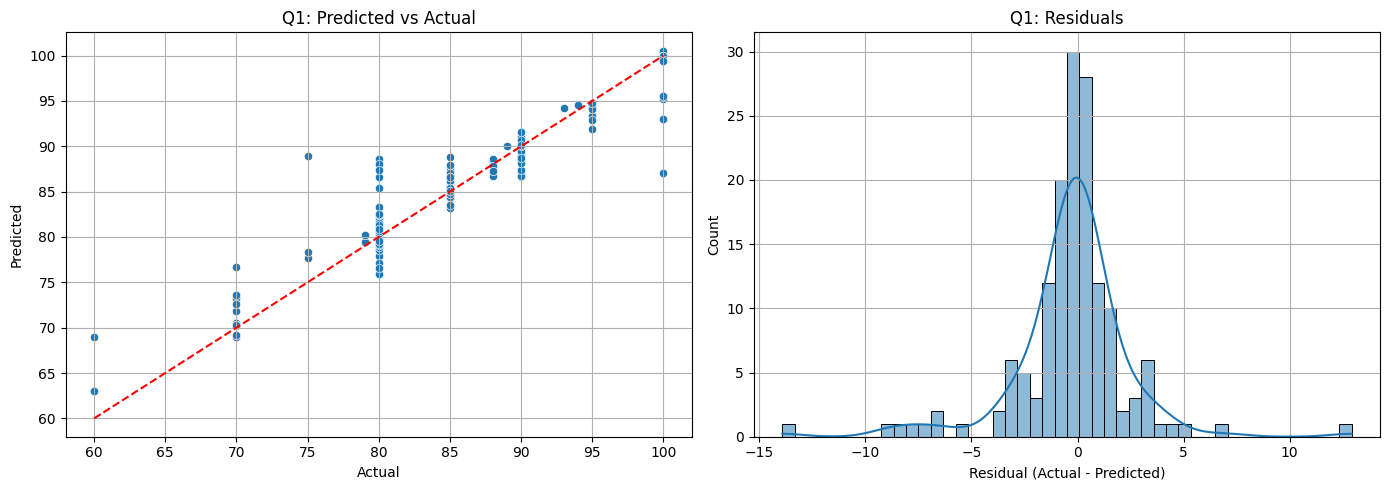

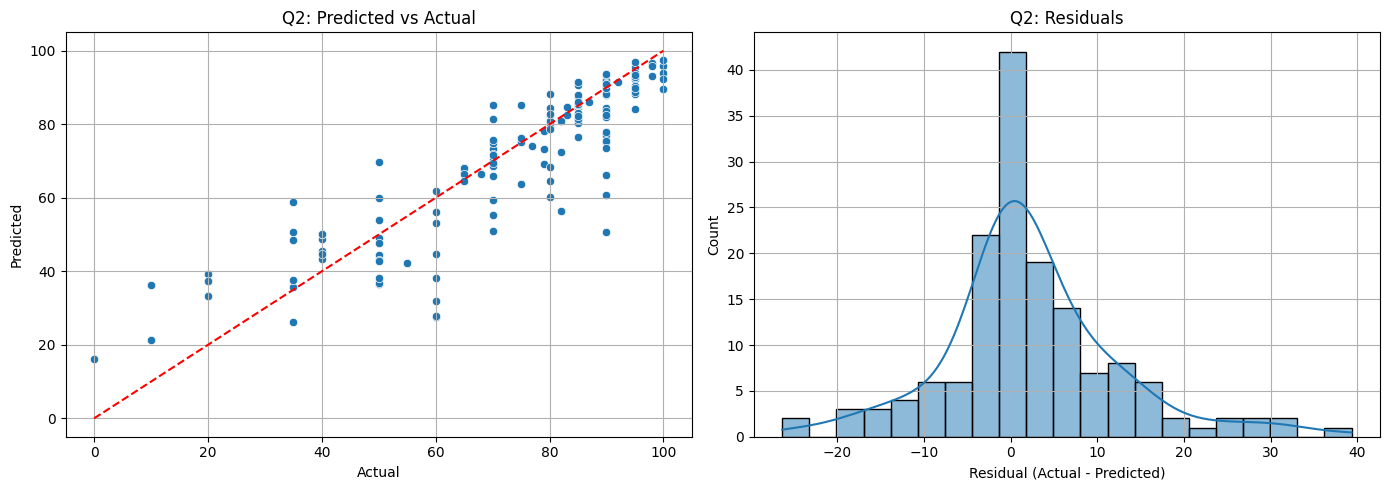

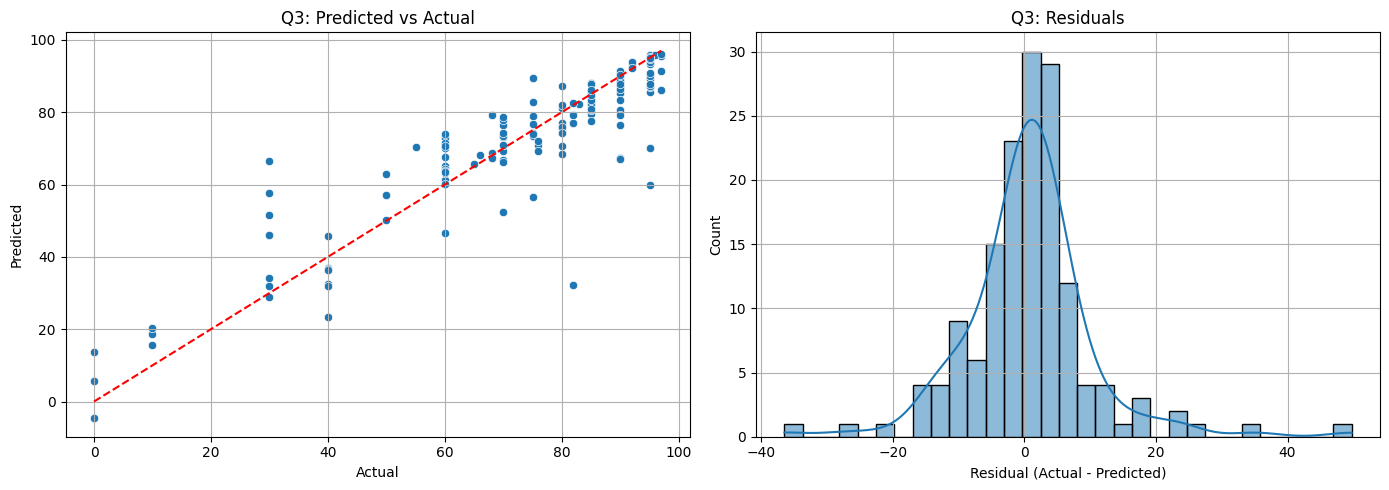

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

questions = ['Q1', 'Q2', 'Q3']

for i, q in enumerate(questions):
    plt.figure(figsize=(14, 5))

    # Predicted vs Actual
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_test[:, i], y=y_pred[:, i])
    plt.plot([y_test[:, i].min(), y_test[:, i].max()],
             [y_test[:, i].min(), y_test[:, i].max()], 'r--')
    plt.title(f'{q}: Predicted vs Actual')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)

    # Residuals plot
    plt.subplot(1, 2, 2)
    residuals = y_test[:, i] - y_pred[:, i]
    sns.histplot(residuals, kde=True)
    plt.title(f'{q}: Residuals')
    plt.xlabel('Residual (Actual - Predicted)')
    plt.ylabel('Count')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Category modification ( 6 + 3)

In [16]:
import pandas as pd
import glob
import os

In [12]:
survey_path = '/content/drive/MyDrive/AIRS/PERCEPTUAL SURVEY'

In [13]:
def get_response_score(row):
    score_map = {'SA': 5, 'A': 4, 'U': 3, 'D': 2, 'SD': 1}
    for col in ['SA', 'A', 'U', 'D', 'SD']:
        val = str(row.get(col)).strip().lower()
        if val == 'x':
            return score_map[col]
        elif val in ['strongly agree', 'sa'] and col == 'SA':
            return 5
        elif val in ['agree', 'a'] and col == 'A':
            return 4
        elif val in ['uncertain', 'u'] and col == 'U':
            return 3
        elif val in ['disagree', 'd'] and col == 'D':
            return 2
        elif val in ['strongly disagree', 'sd'] and col == 'SD':
            return 1
    return None

In [14]:
def process_excel(file_path, subj_id):
    df = pd.read_excel(file_path, header=None)
    df.columns = ['Question', 'SA', 'A', 'U', 'D', 'SD']
    df = df[df['Question'].notna()].copy()
    df['Score'] = df.apply(get_response_score, axis=1)
    df['Subject'] = subj_id
    return df[['Subject', 'Question', 'Score']]

In [17]:
survey_files = sorted(glob.glob(os.path.join(survey_path, '*.xlsx')))
all_dfs = [process_excel(file, subj_id=i+1) for i, file in enumerate(survey_files)]

In [18]:
final_survey_df = pd.concat(all_dfs, ignore_index=True)
final_survey_df.shape

(570, 3)

570 points cause of 19 x 30 and 3 for Sub, Que and Score

In [ ]:
category_map = {
    'Group': [3, 4, 5, 21, 23],
    'Visual': [6, 10, 12, 24, 29],
    'Auditory': [1, 7, 9, 17, 20],
    'Kinesthetic': [2, 8, 11, 14, 15],
    'Individual': [13, 18, 27, 28, 30],
    'Tactile': [16, 19, 22, 25, 26],
}

In [ ]:
def assign_category(row):
    try:
        q_num = int(str(row['Question']).split('.')[0].strip())
        for cat, questions in category_map.items():
            if q_num in questions:
                return cat
    except:
        pass
    return 'Unknown'

In [ ]:
final_survey_df['Category'] = final_survey_df.apply(assign_category, axis=1)

In [ ]:
final_survey_df['Score'] = pd.to_numeric(final_survey_df['Score'], errors='coerce')

In [ ]:
agg_df = final_survey_df.groupby(['Subject', 'Category'])['Score'].sum().reset_index()
agg_df['Score_Normalized'] = (agg_df['Score'] / 25) * 100

In [ ]:
final_category_df = agg_df.pivot(index='Subject', columns='Category', values='Score_Normalized').reset_index()

In [ ]:
final_category_df = final_category_df.fillna(0)

In [ ]:
print("Final Category Scores for All Subjects:")
print(final_category_df)

Final Category Scores for All Subjects:
Category  Subject  Auditory  Group  Individual  Kinesthetic  Tactile  Visual
0               1      64.0   76.0        60.0         88.0     80.0    40.0
1               2      84.0   92.0        80.0         84.0     96.0    80.0
2               3      64.0   84.0        52.0         84.0     88.0    80.0
3               4      80.0   80.0        56.0         84.0     92.0    76.0
4               5      80.0   80.0        56.0         84.0     92.0    76.0
5               6      84.0   68.0        76.0         96.0     96.0    72.0
6               7      92.0   76.0        36.0        100.0     76.0    32.0
7               8      64.0   44.0        76.0         80.0     72.0    68.0
8               9      60.0   36.0        96.0         80.0     64.0    72.0
9              10      76.0   68.0        40.0         80.0     72.0    72.0
10             11      72.0   60.0        64.0         88.0     80.0    64.0
11             12      84.0   88.0  

subject 20 - not available; hence taking the median for sub 20

In [ ]:
print("Combined dataset shape:", combined_df.shape)
print(combined_df.head())

Combined dataset shape: (2280, 331)
   ch0_delta  ch0_theta  ch0_alpha   ch0_beta  ch0_gamma  ch1_delta  \
0  58.579982   9.832955   3.353836  11.649046  10.161449  43.510715   
1  58.579982   9.832955   3.353836  11.649046  10.161449  43.510715   
2  58.579982   9.832955   3.353836  11.649046  10.161449  43.510715   
3  46.378695   8.339626   3.538782   9.046374  10.394174  37.365714   
4  46.378695   8.339626   3.538782   9.046374  10.394174  37.365714   

   ch1_theta  ch1_alpha   ch1_beta  ch1_gamma  ...  Condition  Trial  \
0   6.229242   2.729521  27.112146  31.230760  ...          1      1   
1   6.229242   2.729521  27.112146  31.230760  ...          1      1   
2   6.229242   2.729521  27.112146  31.230760  ...          1      1   
3   5.622269   2.994647  20.574303  26.342392  ...          1      2   
4   5.622269   2.994647  20.574303  26.342392  ...          1      2   

   Question  Score  Auditory  Group  Individual  Kinesthetic  Tactile  Visual  
0        Q1     95      

In [ ]:
print("Final Category Scores:")
print(final_category_df)

Final Category Scores:
Category  Subject  Auditory  Group  Individual  Kinesthetic  Tactile  Visual
0               1      64.0   76.0        60.0         88.0     80.0    40.0
1               2      84.0   92.0        80.0         84.0     96.0    80.0
2               3      64.0   84.0        52.0         84.0     88.0    80.0
3               4      80.0   80.0        56.0         84.0     92.0    76.0
4               5      80.0   80.0        56.0         84.0     92.0    76.0
5               6      84.0   68.0        76.0         96.0     96.0    72.0
6               7      92.0   76.0        36.0        100.0     76.0    32.0
7               8      64.0   44.0        76.0         80.0     72.0    68.0
8               9      60.0   36.0        96.0         80.0     64.0    72.0
9              10      76.0   68.0        40.0         80.0     72.0    72.0
10             11      72.0   60.0        64.0         88.0     80.0    64.0
11             12      84.0   88.0       100.0       

In [ ]:
median_row = final_category_df.drop(columns=['Subject']).median(numeric_only=True)


subject_20_row = pd.DataFrame([median_row])
subject_20_row.insert(0, 'Subject', 20)  # Insert Subject ID as first column

final_category_df = pd.concat([final_category_df, subject_20_row], ignore_index=True)

final_category_df = final_category_df.sort_values(by='Subject').reset_index(drop=True)

print("Final Category Scores with Subject 20 added (median-filled):")
print(final_category_df[final_category_df['Subject'] == 20])

Final Category Scores with Subject 20 added (median-filled):
Category  Subject  Auditory  Group  Individual  Kinesthetic  Tactile  Visual
19             20      76.0   68.0        64.0         84.0     80.0    72.0


In [ ]:
final_category_df

Category,Subject,Auditory,Group,Individual,Kinesthetic,Tactile,Visual
0,1,64.0,76.0,60.0,88.0,80.0,40.0
1,2,84.0,92.0,80.0,84.0,96.0,80.0
2,3,64.0,84.0,52.0,84.0,88.0,80.0
3,4,80.0,80.0,56.0,84.0,92.0,76.0
4,5,80.0,80.0,56.0,84.0,92.0,76.0
5,6,84.0,68.0,76.0,96.0,96.0,72.0
6,7,92.0,76.0,36.0,100.0,76.0,32.0
7,8,64.0,44.0,76.0,80.0,72.0,68.0
8,9,60.0,36.0,96.0,80.0,64.0,72.0
9,10,76.0,68.0,40.0,80.0,72.0,72.0


In [ ]:
# Define your target path
output_path = '/content/drive/MyDrive/AIRS/combined_dataset.csv'

# Save to CSV
combined_df.to_csv(output_path, index=False)

print(f"combined_df saved to: {output_path}")

combined_df saved to: /content/drive/MyDrive/AIRS/combined_dataset.csv


In [ ]:
import pandas as pd

combined_df = pd.read_csv('/content/drive/MyDrive/AIRS/combined_dataset.csv')

# Display shape and columns
print("Shape:", combined_df.shape)
print("Columns:\n", combined_df.columns.tolist())

Shape: (2280, 331)
Columns:
 ['ch0_delta', 'ch0_theta', 'ch0_alpha', 'ch0_beta', 'ch0_gamma', 'ch1_delta', 'ch1_theta', 'ch1_alpha', 'ch1_beta', 'ch1_gamma', 'ch2_delta', 'ch2_theta', 'ch2_alpha', 'ch2_beta', 'ch2_gamma', 'ch3_delta', 'ch3_theta', 'ch3_alpha', 'ch3_beta', 'ch3_gamma', 'ch4_delta', 'ch4_theta', 'ch4_alpha', 'ch4_beta', 'ch4_gamma', 'ch5_delta', 'ch5_theta', 'ch5_alpha', 'ch5_beta', 'ch5_gamma', 'ch6_delta', 'ch6_theta', 'ch6_alpha', 'ch6_beta', 'ch6_gamma', 'ch7_delta', 'ch7_theta', 'ch7_alpha', 'ch7_beta', 'ch7_gamma', 'ch8_delta', 'ch8_theta', 'ch8_alpha', 'ch8_beta', 'ch8_gamma', 'ch9_delta', 'ch9_theta', 'ch9_alpha', 'ch9_beta', 'ch9_gamma', 'ch10_delta', 'ch10_theta', 'ch10_alpha', 'ch10_beta', 'ch10_gamma', 'ch11_delta', 'ch11_theta', 'ch11_alpha', 'ch11_beta', 'ch11_gamma', 'ch12_delta', 'ch12_theta', 'ch12_alpha', 'ch12_beta', 'ch12_gamma', 'ch13_delta', 'ch13_theta', 'ch13_alpha', 'ch13_beta', 'ch13_gamma', 'ch14_delta', 'ch14_theta', 'ch14_alpha', 'ch14_beta',

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AIRS/combined_dataset.csv')
print("Loaded dataset shape:", df.shape)

Loaded dataset shape: (2280, 331)


In [ ]:
feature_cols = [col for col in df.columns if 'ch' in col]  # EEG features
X = df[feature_cols]

In [ ]:
output_cols = ['Q1_score', 'Q2_score', 'Q3_score', 'Auditory', 'Group', 'Individual', 'Kinesthetic', 'Tactile', 'Visual']

In [ ]:
missing_outputs = [col for col in output_cols if col not in df.columns]
if missing_outputs:
    print("Missing output columns:", missing_outputs)

Missing output columns: ['Q1_score', 'Q2_score', 'Q3_score']


In [ ]:
import pandas as pd

# Load your current dataset
df = pd.read_csv('/content/drive/MyDrive/AIRS/combined_dataset.csv')

# Check current structure
print("Before pivot:", df.shape)
print(df[['Subject', 'Condition', 'Trial', 'Question', 'Score']].head())

# Convert Question values to standard Q1, Q2, Q3 strings if needed
df['Question'] = df['Question'].replace({1: 'Q1', 2: 'Q2', 3: 'Q3'})

# Pivot the dataset to wide format for Q1, Q2, Q3
pivot_df = df.pivot_table(
    index=['Subject', 'Condition', 'Trial'],
    columns='Question',
    values='Score'
).reset_index()

# Rename columns for clarity
pivot_df.columns.name = None
pivot_df = pivot_df.rename(columns={
    'Q1': 'Q1_score',
    'Q2': 'Q2_score',
    'Q3': 'Q3_score'
})

features_df = df.drop(columns=['Question', 'Score']).drop_duplicates(subset=['Subject', 'Condition', 'Trial'])

final_df = features_df.merge(
    pivot_df,
    on=['Subject', 'Condition', 'Trial'],
    how='inner'
)

print("Final pivoted dataset shape:", final_df.shape)
print("Columns:", final_df.columns.tolist())

# Save the new clean dataset
final_df.to_csv('/content/drive/MyDrive/AIRS/final_9_outputs_pivoted.csv', index=False)
print("Saved as final_9_outputs_pivoted.csv")

Before pivot: (2280, 331)
   Subject  Condition  Trial Question  Score
0        1          1      1       Q1     95
1        1          1      1       Q2     90
2        1          1      1       Q3     92
3        1          1      2       Q1     95
4        1          1      2       Q2     90
Final pivoted dataset shape: (760, 332)
Columns: ['ch0_delta', 'ch0_theta', 'ch0_alpha', 'ch0_beta', 'ch0_gamma', 'ch1_delta', 'ch1_theta', 'ch1_alpha', 'ch1_beta', 'ch1_gamma', 'ch2_delta', 'ch2_theta', 'ch2_alpha', 'ch2_beta', 'ch2_gamma', 'ch3_delta', 'ch3_theta', 'ch3_alpha', 'ch3_beta', 'ch3_gamma', 'ch4_delta', 'ch4_theta', 'ch4_alpha', 'ch4_beta', 'ch4_gamma', 'ch5_delta', 'ch5_theta', 'ch5_alpha', 'ch5_beta', 'ch5_gamma', 'ch6_delta', 'ch6_theta', 'ch6_alpha', 'ch6_beta', 'ch6_gamma', 'ch7_delta', 'ch7_theta', 'ch7_alpha', 'ch7_beta', 'ch7_gamma', 'ch8_delta', 'ch8_theta', 'ch8_alpha', 'ch8_beta', 'ch8_gamma', 'ch9_delta', 'ch9_theta', 'ch9_alpha', 'ch9_beta', 'ch9_gamma', 'ch10_delta', 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

In [ ]:
final_df = pd.read_csv('/content/drive/MyDrive/AIRS/final_9_outputs_pivoted.csv')
print("Dataset shape:", final_df.shape)

Dataset shape: (760, 332)


In [ ]:
# Define input X and output y
output_cols = ['Q1_score', 'Q2_score', 'Q3_score', 'Auditory', 'Group', 'Individual', 'Kinesthetic', 'Tactile', 'Visual']

In [ ]:
# Define input X and output y
output_cols = ['Q1_score', 'Q2_score', 'Q3_score', 'Auditory', 'Group', 'Individual', 'Kinesthetic', 'Tactile', 'Visual']
feature_cols = [col for col in final_df.columns if 'ch' in col] # EEG features

X = final_df[feature_cols]
y = final_df[output_cols]

In [ ]:
# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize multi-output regressor with XGBoost
model = MultiOutputRegressor(XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1))

In [ ]:
print("Unique subjects in EEG dataset:", df['Subject'].nunique())
print("Unique subjects in learning style categories:", final_category_df['Subject'].nunique())
print("Subjects missing from survey:", set(df['Subject'].unique()) - set(final_category_df['Subject'].unique()))

Unique subjects in EEG dataset: 19
Unique subjects in learning style categories: 20
Subjects missing from survey: set()


In [ ]:
print("Subjects in EEG dataset:", sorted(df['Subject'].unique()))
print("Subjects in survey dataset:", sorted(final_category_df['Subject'].unique()))

Subjects in EEG dataset: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19)]
Subjects in survey dataset: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20)]


In [ ]:
# Calculate median learning styles
medians = final_category_df[['Auditory','Group','Individual','Kinesthetic','Tactile','Visual']].median()

# Impute for subject 8 only
final_df.loc[final_df['Subject'] == 8, ['Auditory','Group','Individual','Kinesthetic','Tactile','Visual']] = medians.values

# Verify
print("Remaining NaNs:\n", final_df[['Auditory','Group','Individual','Kinesthetic','Tactile','Visual']].isna().sum())

Remaining NaNs:
 Auditory       0
Group          0
Individual     0
Kinesthetic    0
Tactile        0
Visual         0
dtype: int64


In [ ]:
final_df

,ch0_delta,ch0_theta,ch0_alpha,ch0_beta,ch0_gamma,ch1_delta,ch1_theta,ch1_alpha,ch1_beta,ch1_gamma,...,Trial,Auditory,Group,Individual,Kinesthetic,Tactile,Visual,Q1_score,Q2_score,Q3_score
0,58.579982,9.832955,3.353836,11.649046,10.161449,43.510715,6.229242,2.729521,27.112146,31.230760,...,1,64.0,76.0,60.0,88.0,80.0,40.0,95.0,90.0,92.0
1,46.378695,8.339626,3.538782,9.046374,10.394174,37.365714,5.622269,2.994647,20.574303,26.342392,...,2,64.0,76.0,60.0,88.0,80.0,40.0,95.0,90.0,92.0
2,32.812305,7.578251,3.699016,11.989093,9.863100,23.379916,5.350025,3.211535,23.105387,25.135091,...,3,64.0,76.0,60.0,88.0,80.0,40.0,95.0,90.0,92.0
3,34.071491,7.868513,3.434858,9.397843,9.426767,28.030302,5.396146,2.915206,20.091046,24.084929,...,4,64.0,76.0,60.0,88.0,80.0,40.0,95.0,90.0,92.0
4,39.920032,9.036787,4.326548,9.555223,9.015601,31.026725,5.912582,3.748570,20.972479,23.127248,...,5,64.0,76.0,60.0,88.0,80.0,40.0,95.0,90.0,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2164.324799,152.032621,94.916636,1376.825446,225.057904,1633.572340,31.277622,10.495813,34.778003,24.546081,...,6,84.0,68.0,60.0,100.0,100.0,100.0,90.0,70.0,90.0
756,2628.629333,404.276068,167.641716,1217.721825,108.520518,744.906273,26.242176,5.753679,31.399687,20.092152,...,7,84.0,68.0,60.0,100.0,100.0,100.0,90.0,70.0,90.0
757,2574.814331,271.001484,135.279529,1011.262010,201.263680,775.859364,40.737607,4.185217,28.991132,15.817168,...,8,84.0,68.0,60.0,100.0,100.0,100.0,90.0,70.0,90.0
758,1867.130234,280.601351,138.973899,1118.109920,334.203026,926.771702,55.379043,5.903536,30.435606,15.038973,...,9,84.0,68.0,60.0,100.0,100.0,100.0,90.0,70.0,90.0


In [ ]:
import pandas as pd


final_df = pd.read_csv('/content/drive/MyDrive/AIRS/final_9_outputs_pivoted.csv')


output_cols = ['Q1_score', 'Q2_score', 'Q3_score',
               'Auditory', 'Group', 'Individual',
               'Kinesthetic', 'Tactile', 'Visual']

print("Checking NaNs per output column:")
print(final_df[output_cols].isna().sum())


nan_rows = final_df[final_df[output_cols].isna().any(axis=1)]
print(f"\nRows with NaNs in output ({nan_rows.shape[0]} rows):")
print(nan_rows[['Subject', 'Condition', 'Trial'] + output_cols])


print("\nDataset shape:", final_df.shape)

Checking NaNs per output column:
Q1_score       0
Q2_score       0
Q3_score       0
Auditory       0
Group          0
Individual     0
Kinesthetic    0
Tactile        0
Visual         0
dtype: int64

Rows with NaNs in output (0 rows):
Empty DataFrame
Columns: [Subject, Condition, Trial, Q1_score, Q2_score, Q3_score, Auditory, Group, Individual, Kinesthetic, Tactile, Visual]
Index: []

Dataset shape: (760, 332)


In [ ]:

for col in output_cols[3:]:  # Only the 6 learning style categories
    median_val = final_df[col].median()
    final_df[col] = final_df[col].fillna(median_val)

print("NaNs filled with medians. Re-check:")
print(final_df[output_cols].isna().sum())

NaNs filled with medians. Re-check:
Q1_score       0
Q2_score       0
Q3_score       0
Auditory       0
Group          0
Individual     0
Kinesthetic    0
Tactile        0
Visual         0
dtype: int64


In [ ]:
final_df

,ch0_delta,ch0_theta,ch0_alpha,ch0_beta,ch0_gamma,ch1_delta,ch1_theta,ch1_alpha,ch1_beta,ch1_gamma,...,Trial,Auditory,Group,Individual,Kinesthetic,Tactile,Visual,Q1_score,Q2_score,Q3_score
0,58.579982,9.832955,3.353836,11.649046,10.161449,43.510715,6.229242,2.729521,27.112146,31.230760,...,1,64.0,76.0,60.0,88.0,80.0,40.0,95.0,90.0,92.0
1,46.378695,8.339626,3.538782,9.046374,10.394174,37.365714,5.622269,2.994647,20.574303,26.342392,...,2,64.0,76.0,60.0,88.0,80.0,40.0,95.0,90.0,92.0
2,32.812305,7.578251,3.699016,11.989093,9.863100,23.379916,5.350025,3.211535,23.105387,25.135091,...,3,64.0,76.0,60.0,88.0,80.0,40.0,95.0,90.0,92.0
3,34.071491,7.868513,3.434858,9.397843,9.426767,28.030302,5.396146,2.915206,20.091046,24.084929,...,4,64.0,76.0,60.0,88.0,80.0,40.0,95.0,90.0,92.0
4,39.920032,9.036787,4.326548,9.555223,9.015601,31.026725,5.912582,3.748570,20.972479,23.127248,...,5,64.0,76.0,60.0,88.0,80.0,40.0,95.0,90.0,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2164.324799,152.032621,94.916636,1376.825446,225.057904,1633.572340,31.277622,10.495813,34.778003,24.546081,...,6,84.0,68.0,60.0,100.0,100.0,100.0,90.0,70.0,90.0
756,2628.629333,404.276068,167.641716,1217.721825,108.520518,744.906273,26.242176,5.753679,31.399687,20.092152,...,7,84.0,68.0,60.0,100.0,100.0,100.0,90.0,70.0,90.0
757,2574.814331,271.001484,135.279529,1011.262010,201.263680,775.859364,40.737607,4.185217,28.991132,15.817168,...,8,84.0,68.0,60.0,100.0,100.0,100.0,90.0,70.0,90.0
758,1867.130234,280.601351,138.973899,1118.109920,334.203026,926.771702,55.379043,5.903536,30.435606,15.038973,...,9,84.0,68.0,60.0,100.0,100.0,100.0,90.0,70.0,90.0


In [ ]:
output_cols = ['Q1_score', 'Q2_score', 'Q3_score',
               'Auditory', 'Group', 'Individual',
               'Kinesthetic', 'Tactile', 'Visual']

In [ ]:
X = final_df[feature_cols].values
y = final_df[output_cols].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model = MultiOutputRegressor(
    XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
)
model.fit(X_train_scaled, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [ ]:
y_pred = model.predict(X_test_scaled)

In [ ]:
# new
for i, col in enumerate(output_cols):
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    rmse = mean_squared_error(y_test[:, i], y_pred[:, i]) ** 0.5


    print(f"Performance for {col}:")
    print(f"   R² Score: {r2:.3f}")
    print(f"   MAE     : {mae:.2f}")
    print(f"   RMSE    : {rmse:.2f}\n")

Performance for Q1_score:
   R² Score: 0.852
   MAE     : 1.67
   RMSE    : 3.04

Performance for Q2_score:
   R² Score: 0.767
   MAE     : 6.33
   RMSE    : 10.23

Performance for Q3_score:
   R² Score: 0.806
   MAE     : 5.89
   RMSE    : 9.80

Performance for Auditory:
   R² Score: 0.860
   MAE     : 1.14
   RMSE    : 3.43

Performance for Group:
   R² Score: 0.916
   MAE     : 2.05
   RMSE    : 5.48

Performance for Individual:
   R² Score: 0.885
   MAE     : 2.42
   RMSE    : 6.20

Performance for Kinesthetic:
   R² Score: 0.871
   MAE     : 1.33
   RMSE    : 3.00

Performance for Tactile:
   R² Score: 0.927
   MAE     : 1.20
   RMSE    : 3.28

Performance for Visual:
   R² Score: 0.955
   MAE     : 1.47
   RMSE    : 3.35



In [ ]:
import joblib

joblib.dump(model, '/content/drive/MyDrive/AIRS/multioutput_xgb_model.pkl')

print("Model saved as multioutput_xgb_model.pkl in your AIRS folder.")

Model saved as multioutput_xgb_model.pkl in your AIRS folder.


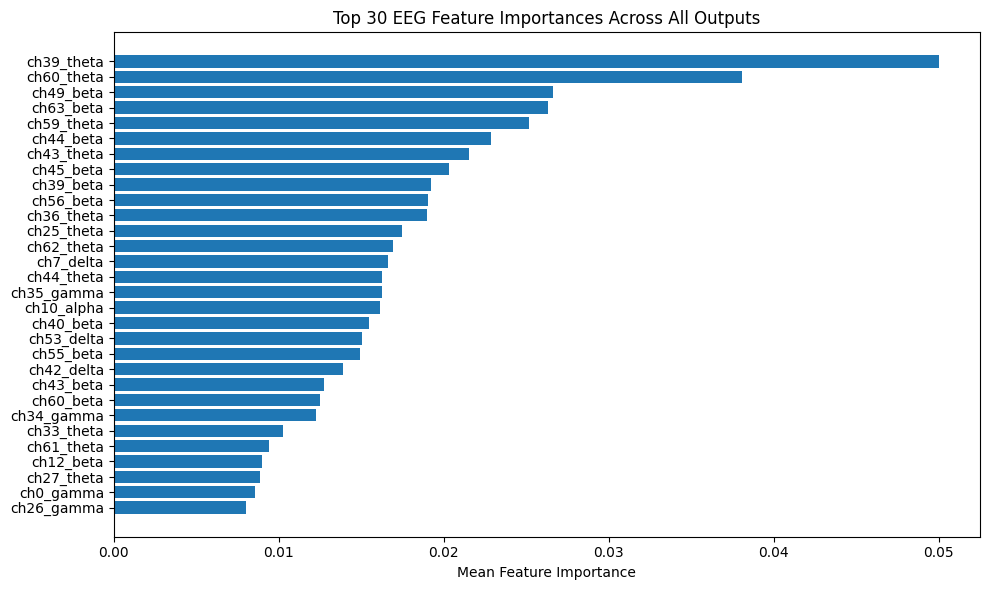

In [ ]:
importances = np.array([est.feature_importances_ for est in model.estimators_])
mean_importance = np.mean(importances, axis=0)


feature_names = feature_cols


top_n = 30
top_indices = np.argsort(mean_importance)[::-1][:top_n]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_indices)), mean_importance[top_indices])
plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
plt.xlabel("Mean Feature Importance")
plt.title(f"Top {top_n} EEG Feature Importances Across All Outputs")
plt.gca().invert_yaxis()  # display the most important feature at the top
plt.tight_layout()
plt.show()

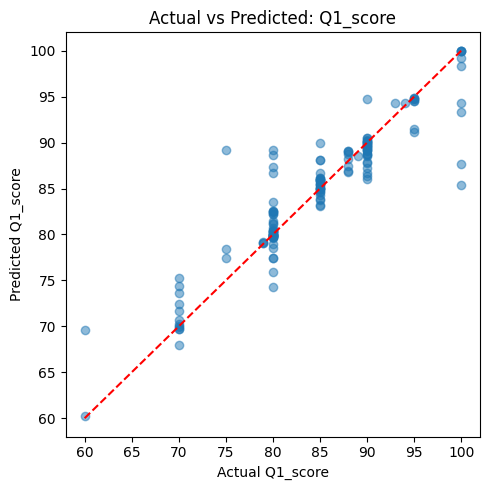

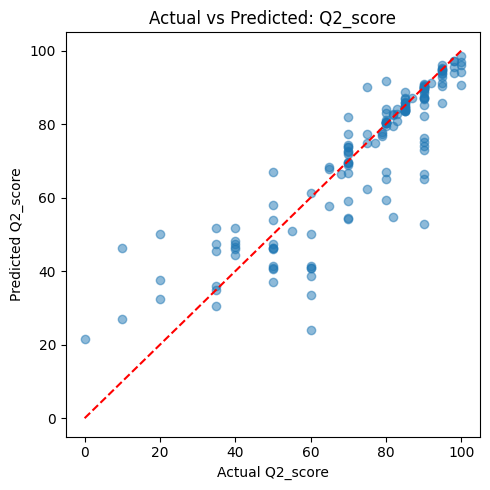

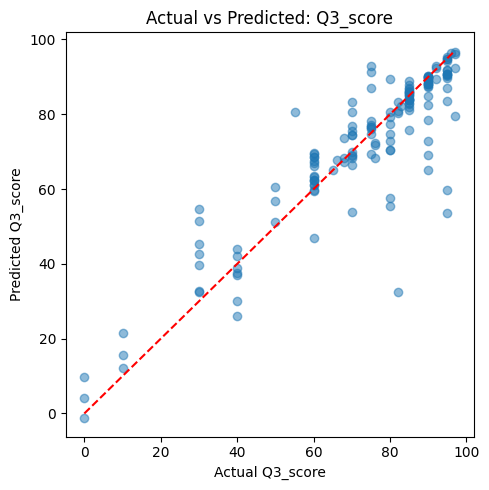

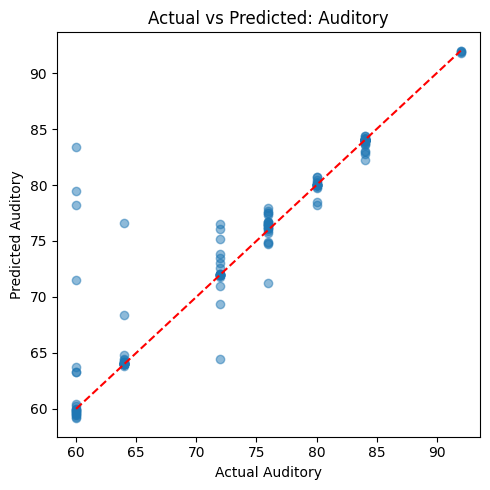

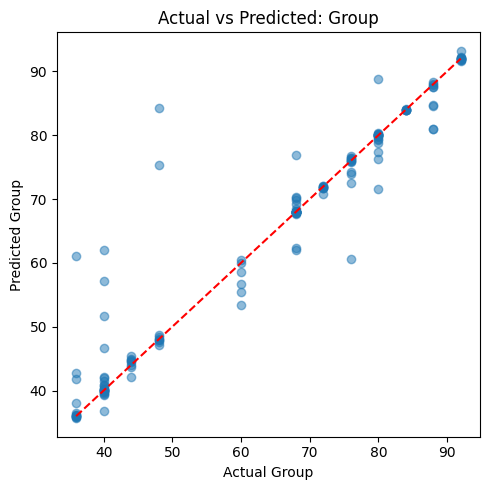

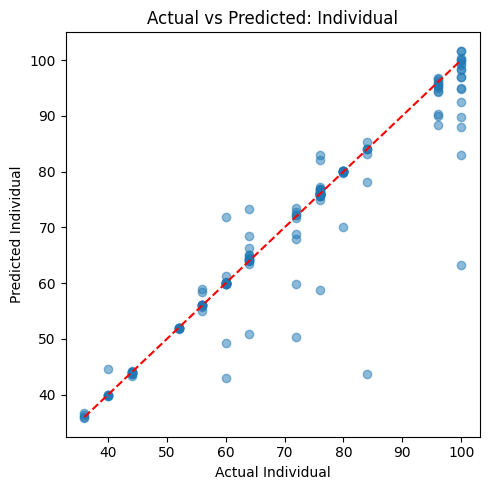

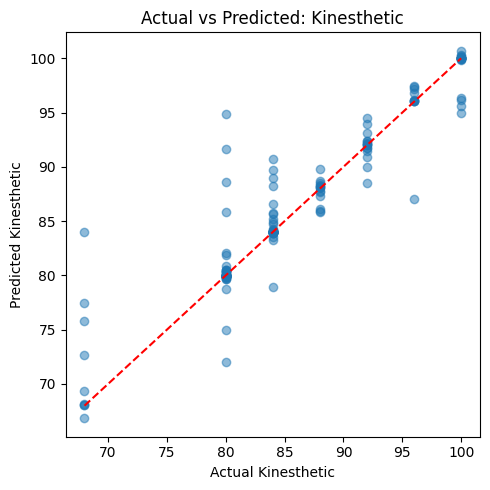

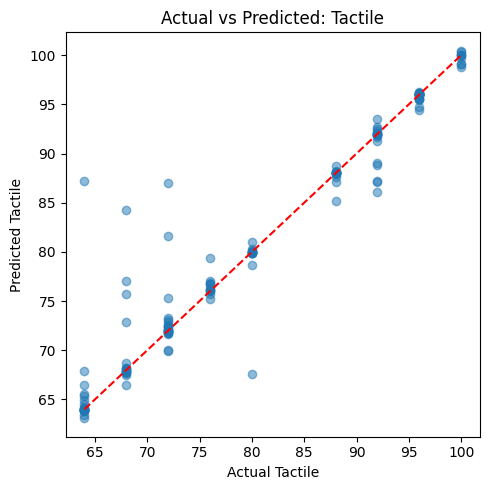

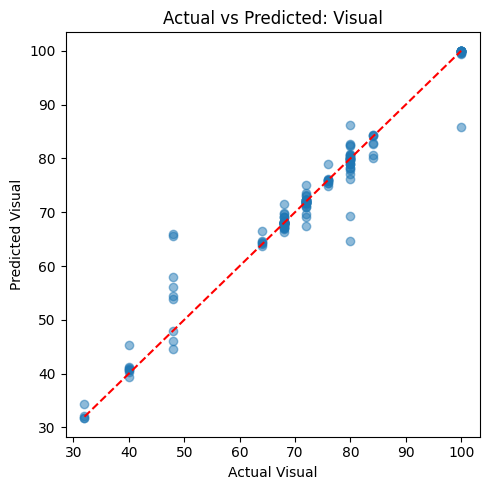

In [ ]:
for i, col in enumerate(output_cols):
    plt.figure(figsize=(5, 5))
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([y_test[:, i].min(), y_test[:, i].max()],
             [y_test[:, i].min(), y_test[:, i].max()], 'r--')
    plt.xlabel(f"Actual {col}")
    plt.ylabel(f"Predicted {col}")
    plt.title(f"Actual vs Predicted: {col}")
    plt.tight_layout()
    plt.show()

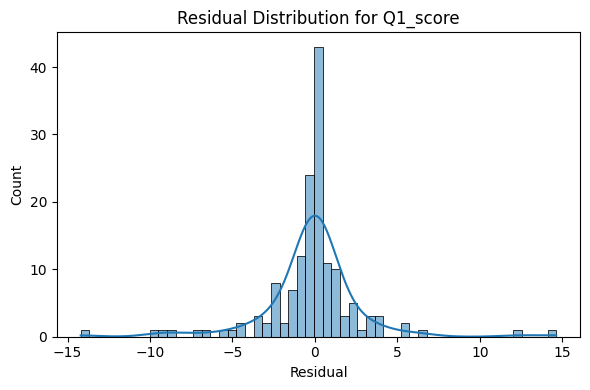

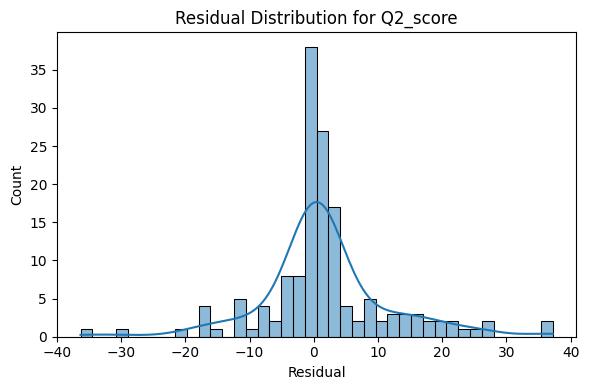

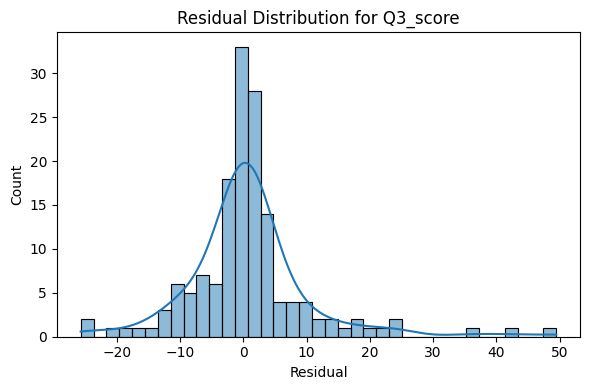

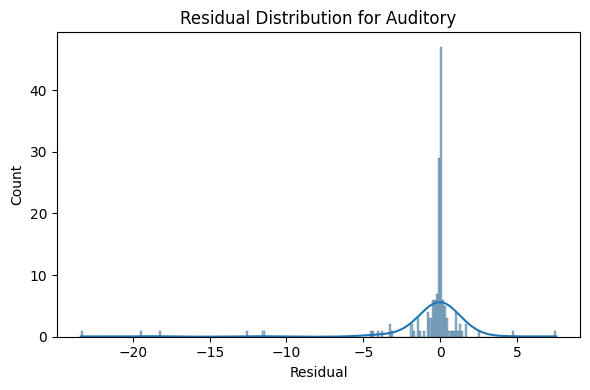

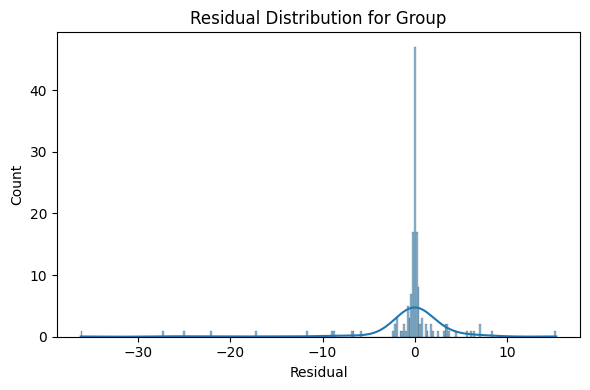

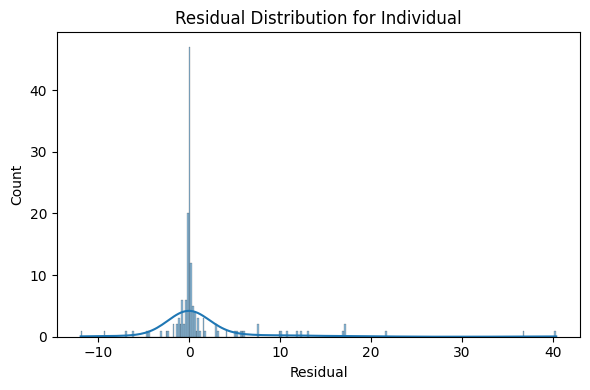

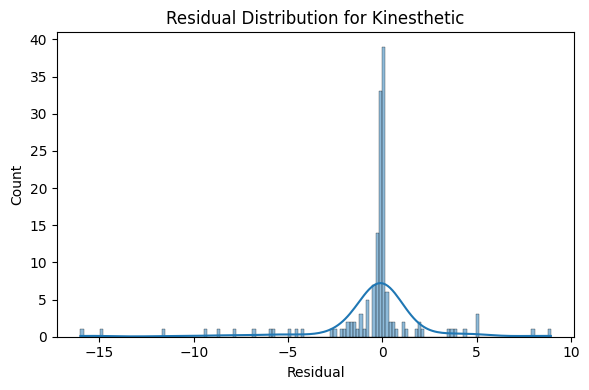

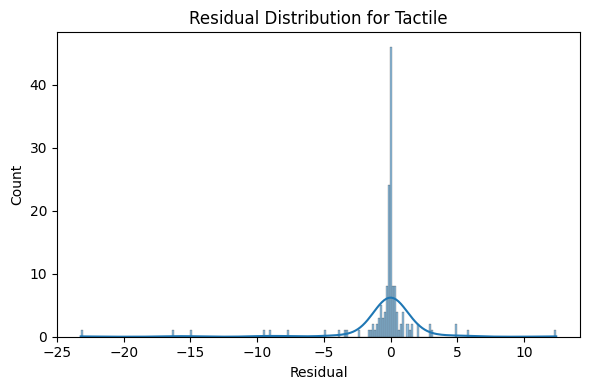

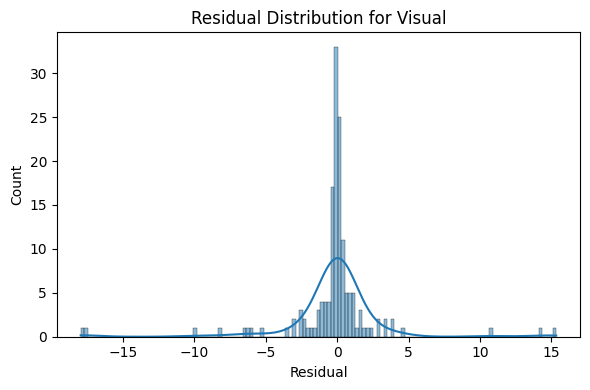

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

output_cols = ['Q1_score', 'Q2_score', 'Q3_score', 'Auditory', 'Group', 'Individual', 'Kinesthetic', 'Tactile', 'Visual']

for i, col in enumerate(output_cols):
    residuals = y_test[:, i] - y_pred[:, i]  # NumPy slicing
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.title(f"Residual Distribution for {col}")
    plt.xlabel("Residual")
    plt.tight_layout()
    plt.show()

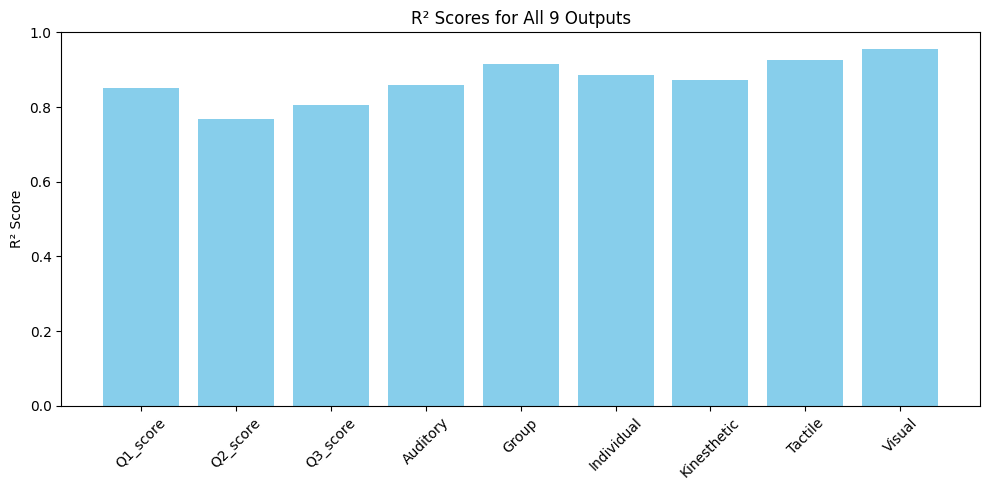

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


output_cols = ['Q1_score', 'Q2_score', 'Q3_score', 'Auditory', 'Group', 'Individual', 'Kinesthetic', 'Tactile', 'Visual']


r2_scores = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]


plt.figure(figsize=(10, 5))
plt.bar(output_cols, r2_scores, color='skyblue')
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.title("R² Scores for All 9 Outputs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

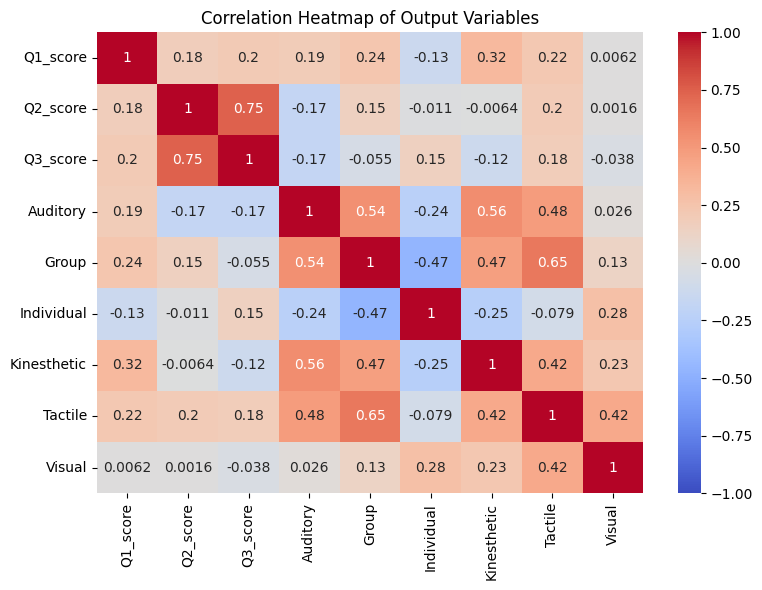

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

output_cols = ['Q1_score', 'Q2_score', 'Q3_score', 'Auditory', 'Group', 'Individual', 'Kinesthetic', 'Tactile', 'Visual']

corr = final_df[output_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Output Variables")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [ ]:
feature_cols = [col for col in final_df if 'ch' in col]  # EEG features
output_cols = ['Q1_score', 'Q2_score', 'Q3_score',
               'Auditory', 'Group', 'Individual',
               'Kinesthetic', 'Tactile', 'Visual']

In [ ]:
X = final_df.copy().drop(columns=['Subject', 'Condition', 'Trial'] + output_cols)
y = final_df[output_cols]

In [ ]:
X_train, X_test, y_train, y_test, condition_train, condition_test = train_test_split(
    X, y, final_df['Condition'], test_size=0.2, random_state=42
)

In [ ]:
knn = make_pipeline(
    StandardScaler(),
    MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5))
)

In [ ]:
knn.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=KNeighborsRegressor()))])

In [ ]:
y_pred_knn = knn.predict(X_test)

In [ ]:
for i, col in enumerate(output_cols):
    # Convert y_test column to numpy array for consistent slicing
    y_test_col = y_test[col].values
    r2 = r2_score(y_test_col, y_pred_knn[:, i])
    mae = mean_absolute_error(y_test_col, y_pred_knn[:, i])
    rmse = mean_squared_error(y_test_col, y_pred_knn[:, i]) ** 0.5

    print(f"Performance for {col}:")
    print(f"R² Score: {r2:.3f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}\n")

Performance for Q1_score:
R² Score: 0.876
MAE: 1.39
RMSE: 2.78

Performance for Q2_score:
R² Score: 0.442
MAE: 7.82
RMSE: 15.83

Performance for Q3_score:
R² Score: 0.535
MAE: 7.17
RMSE: 15.18

Performance for Auditory:
R² Score: 0.883
MAE: 0.74
RMSE: 3.14

Performance for Group:
R² Score: 0.932
MAE: 1.53
RMSE: 4.94

Performance for Individual:
R² Score: 0.908
MAE: 1.97
RMSE: 5.55

Performance for Kinesthetic:
R² Score: 0.850
MAE: 0.98
RMSE: 3.23

Performance for Tactile:
R² Score: 0.960
MAE: 0.66
RMSE: 2.43

Performance for Visual:
R² Score: 0.838
MAE: 1.93
RMSE: 6.34



In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
))

In [ ]:
rf.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor(n_jobs=-1,
                                                     random_state=42))

In [ ]:
y_pred_rf = rf.predict(X_test)

In [ ]:
for i, col in enumerate(output_cols):
    y_test_col = y_test[col].values
    r2 = r2_score(y_test_col, y_pred_rf[:, i])
    mae = mean_absolute_error(y_test_col, y_pred_rf[:, i])
    rmse = mean_squared_error(y_test_col, y_pred_rf[:, i]) ** 0.5

    print(f"Performance for {col}:")
    print(f"R² Score: {r2:.3f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}\n")

Performance for Q1_score:
R² Score: 0.892
MAE: 1.53
RMSE: 2.59

Performance for Q2_score:
R² Score: 0.735
MAE: 7.08
RMSE: 10.90

Performance for Q3_score:
R² Score: 0.793
MAE: 6.58
RMSE: 10.12

Performance for Auditory:
R² Score: 0.886
MAE: 1.11
RMSE: 3.09

Performance for Group:
R² Score: 0.925
MAE: 2.18
RMSE: 5.18

Performance for Individual:
R² Score: 0.916
MAE: 2.45
RMSE: 5.31

Performance for Kinesthetic:
R² Score: 0.841
MAE: 1.61
RMSE: 3.32

Performance for Tactile:
R² Score: 0.950
MAE: 1.17
RMSE: 2.71

Performance for Visual:
R² Score: 0.902
MAE: 1.89
RMSE: 4.93



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

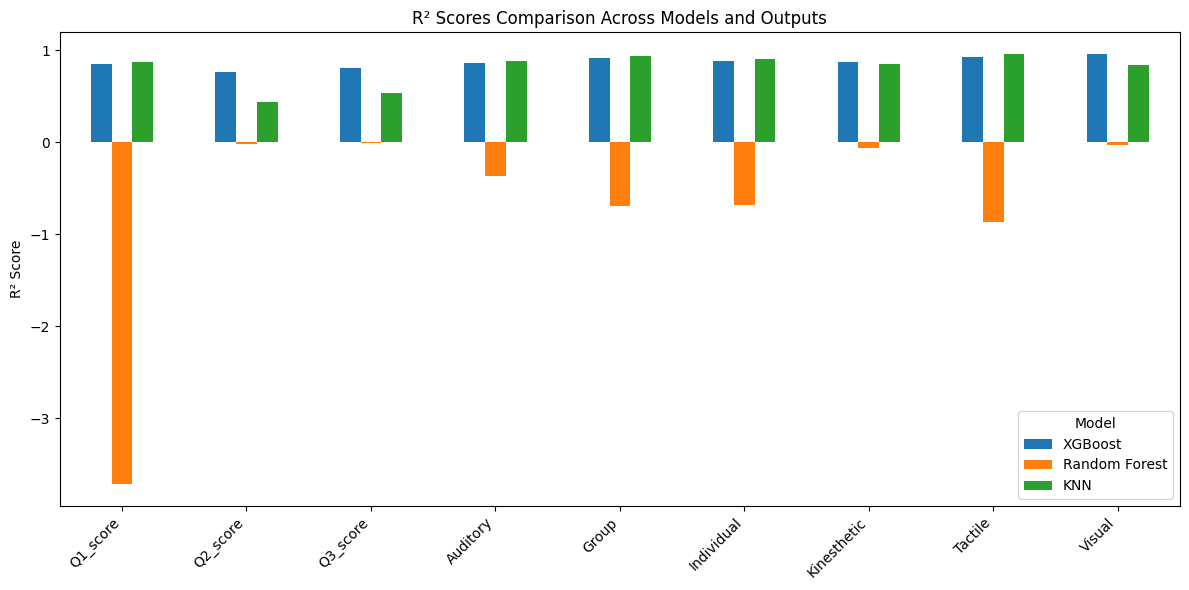

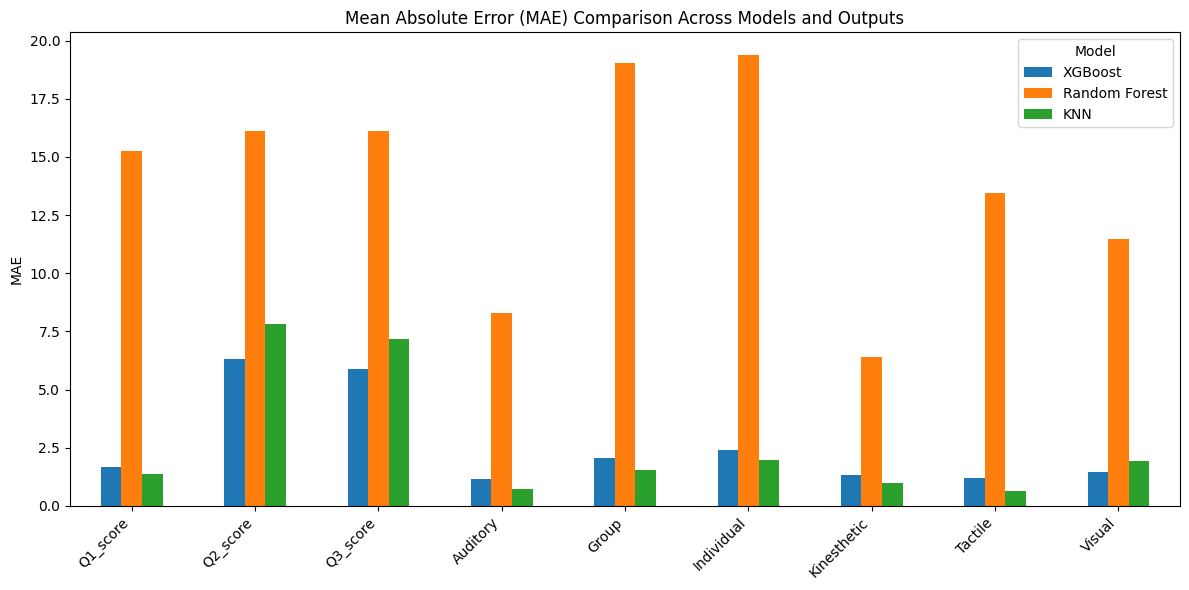

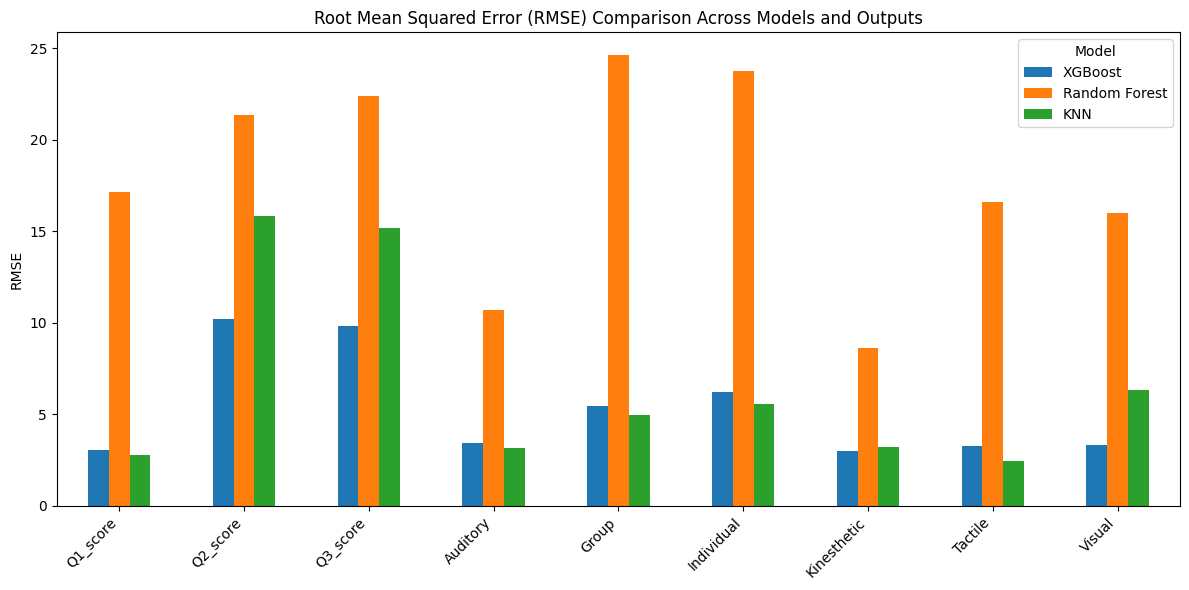

In [ ]:
# Calculate R2, MAE, and RMSE for all models and output variables
r2_scores = {}
mae_scores = {}
rmse_scores = {}

models = {
    'XGBoost': model,
    'Random Forest': rf,
    'KNN': knn
}

for name, regressor in models.items():
    if name == 'KNN':
        y_pred = regressor.predict(X_test) # KNN pipeline includes scaling
    else:
        y_pred = regressor.predict(X_test_scaled) # XGBoost and RF need scaled data

    r2_scores[name] = [r2_score(y_test[col].values, y_pred[:, i]) for i, col in enumerate(output_cols)]
    mae_scores[name] = [mean_absolute_error(y_test[col].values, y_pred[:, i]) for i, col in enumerate(output_cols)]
    rmse_scores[name] = [mean_squared_error(y_test[col].values, y_pred[:, i]) ** 0.5 for i, col in enumerate(output_cols)]

# Create DataFrames for easier plotting
r2_df = pd.DataFrame(r2_scores, index=output_cols)
mae_df = pd.DataFrame(mae_scores, index=output_cols)
rmse_df = pd.DataFrame(rmse_scores, index=output_cols)

# Plot R2 scores
r2_df.plot(kind='bar', figsize=(12, 6))
plt.title('R² Scores Comparison Across Models and Outputs')
plt.ylabel('R² Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Plot MAE scores
mae_df.plot(kind='bar', figsize=(12, 6))
plt.title('Mean Absolute Error (MAE) Comparison Across Models and Outputs')
plt.ylabel('MAE')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Plot RMSE scores
rmse_df.plot(kind='bar', figsize=(12, 6))
plt.title('Root Mean Squared Error (RMSE) Comparison Across Models and Outputs')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Dividing it into condition wise

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Create a copy of X_test and add the 'Condition' column
X_test_with_condition = X_test.copy()
X_test_with_condition["Condition"] = condition_test

# Create DataFrames for y_test and y_pred for easier merging
output_columns = y_test.columns.tolist() # Get column names from y_test DataFrame
y_test_df = pd.DataFrame(y_test, columns=output_columns)
y_pred_df = pd.DataFrame(y_pred, columns=output_columns)

# Merge the actual and predicted values with the condition information
comparison_df = X_test_with_condition.merge(
    y_test_df.reset_index(drop=True), # Reset index to merge on default index
    left_index=True,
    right_index=True
).merge(
    y_pred_df.reset_index(drop=True), # Reset index to merge on default index
    left_index=True,
    right_index=True,
    suffixes=('_actual', '_predicted')
)

print("Comparison DataFrame with Conditions:")
display(comparison_df.head())

Comparison DataFrame with Conditions:


,ch0_delta,ch0_theta,ch0_alpha,ch0_beta,ch0_gamma,ch1_delta,ch1_theta,ch1_alpha,ch1_beta,ch1_gamma,...,Visual_actual,Q1_score_predicted,Q2_score_predicted,Q3_score_predicted,Auditory_predicted,Group_predicted,Individual_predicted,Kinesthetic_predicted,Tactile_predicted,Visual_predicted
97,132.343726,21.952441,16.016393,12.070368,2.759353,476.345741,597.863827,507.810335,350.795166,41.071341,...,72.0,84.0,89.0,88.0,60.0,36.0,96.0,80.0,64.0,72.0
109,340.729692,39.756245,11.875705,18.452697,9.038139,204735.501953,49069.368164,16720.848877,3727.971807,393.597938,...,76.0,100.0,82.0,82.0,80.0,80.0,56.0,84.0,92.0,76.0
78,1245.645754,62.584369,14.903503,152.272248,111.009675,629.797388,43.229842,8.944835,24.974572,18.505078,...,80.0,84.0,76.0,76.0,84.0,82.4,72.0,90.4,97.6,88.0
39,45.667496,7.874487,3.516619,8.940360,5.405660,37.278994,5.106476,2.735860,12.546303,11.905886,...,72.0,90.0,84.0,85.0,84.0,68.0,76.0,96.0,96.0,72.0
31,64.715944,9.488451,5.226088,12.750921,11.110330,50.286574,6.957816,3.881768,22.969151,30.673600,...,80.0,80.0,83.0,83.0,60.0,48.0,72.0,80.0,72.0,80.0


In [ ]:
output_labels = y_test.columns.tolist()
y_pred_all = pd.DataFrame(model.predict(X_test), columns=output_labels)

In [ ]:
condition_name_map = {1: "NF", 2: "VF", 3: "HF", 4: "VHF"}
condition_metrics = []

In [ ]:
for cond_num, cond_name in condition_name_map.items():
    cond_idx = X_test_with_condition[X_test_with_condition["Condition"] == cond_num].index.tolist()
    if len(cond_idx) == 0:
        continue

    # Reset index of y_test and y_pred_all to match integer index
    y_true_cond = y_test.reset_index(drop=True).loc[X_test.reset_index(drop=True).index.isin(cond_idx)]
    y_pred_cond = y_pred_all.reset_index(drop=True).loc[X_test.reset_index(drop=True).index.isin(cond_idx)]

    for col in output_labels:
        r2 = r2_score(y_true_cond[col], y_pred_cond[col])
        mae = mean_absolute_error(y_true_cond[col], y_pred_cond[col])
        rmse = mean_squared_error(y_true_cond[col], y_pred_cond[col]) ** 0.5

        condition_metrics.append({
            "Condition": cond_name,
            "Output": col,
            "R2": r2,
            "MAE": mae,
            "RMSE": rmse
        })

In [ ]:
merged_test_df = pd.concat([X_test_with_condition.reset_index(drop=True),
                            y_test_df.reset_index(drop=True),
                            y_pred_df.add_suffix("_pred").reset_index(drop=True)], axis=1)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

condition_metrics = []

for output in output_columns:
    for condition in merged_test_df['Condition'].unique():
        cond_df = merged_test_df[merged_test_df['Condition'] == condition]
        mse = mean_squared_error(cond_df[output], cond_df[f"{output}_pred"])
        rmse = np.sqrt(mse)
        condition_metrics.append({
            'Output': output,
            'Condition': condition,
            'RMSE': rmse
        })

condition_metrics_df = pd.DataFrame(condition_metrics)

<Figure size 1400x600 with 0 Axes>

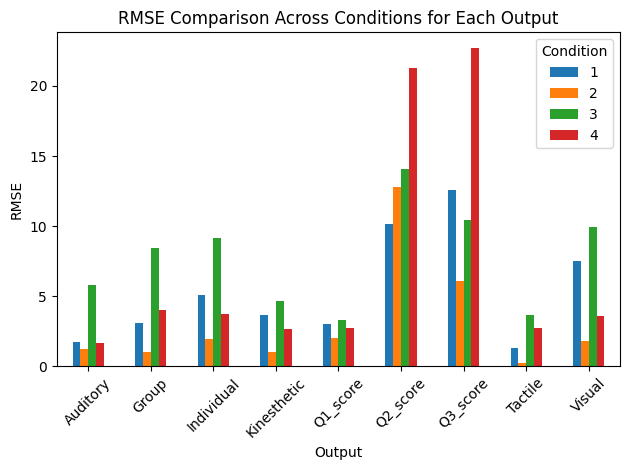

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

pivot_df = condition_metrics_df.pivot_table(index='Output', columns='Condition', values='RMSE', aggfunc='mean')

plt.figure(figsize=(14,6))
pivot_df.plot(kind='bar')
plt.title("RMSE Comparison Across Conditions for Each Output")
plt.ylabel("RMSE")
plt.xlabel("Output")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
display(condition_metrics_df.pivot_table(index='Output', columns='Condition', values='RMSE', aggfunc='mean'))

Condition,1,2,3,4
Output,,,,
Auditory,1.749286,1.214724,5.793483,1.677299
Group,3.124100,1.041367,8.475848,4.016632
Individual,5.104900,1.977653,9.176782,3.755884
Kinesthetic,3.646917,1.024153,4.679981,2.650786
Q1_score,3.009568,1.992486,3.298148,2.702776
Q2_score,10.184793,12.768581,14.081864,21.289943
Q3_score,12.582031,6.100000,10.437326,22.684980
Tactile,1.334166,0.230940,3.668484,2.712932
Visual,7.531268,1.798765,9.951884,3.557152


# Dataset with PCA analysis

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pca_df = pd.read_csv('/content/drive/MyDrive/AIRS/final_9_outputs_pivoted.csv')

In [ ]:
pca_df = pca_df.rename(columns={
    'Q1_score': 'Agency',
    'Q2_score': 'Motivation',
    'Q3_score': 'Utility'
})

In [ ]:
output_cols = ['Agency','Motivation','Utility','Auditory','Group','Individual','Kinesthetic','Tactile','Visual']
conds      = pca_df['Condition'].values
feature_cols = [c for c in pca_df.columns if c not in ['Subject','Condition','Trial'] + output_cols]

In [ ]:
X = pca_df[feature_cols]
y = pca_df[output_cols]

In [ ]:
X_tr, X_te, y_tr, y_te, cond_tr, cond_te = train_test_split(
    X, y, conds,
    test_size=0.2,
    random_state=42,
    stratify=conds
)

In [ ]:
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

In [ ]:
selected_bands = ['alpha', 'beta', 'gamma','theta']
pcs_per_band   = 20  # number of PCs per band (cap at #channels)

X_tr_s_df = pd.DataFrame(X_tr_s, columns=feature_cols)
X_te_s_df = pd.DataFrame(X_te_s, columns=feature_cols)

band_cols = {}
for b in selected_bands:
    cols = [c for c in feature_cols if c.endswith(f'_{b}')]
    if len(cols) == 0:
        raise ValueError(f"No columns found for band '{b}'. "
                         f"Check your feature names like 'ch0_{b}'.")
    band_cols[b] = cols

Xtr_parts, Xte_parts = [], []
explained_per_band = {}

for b in selected_bands:
    cols = band_cols[b]
    n_feat_band = len(cols)
    n_comp = min(pcs_per_band, n_feat_band)

    pca = PCA(n_components=n_comp, random_state=42)
    Xtr_b = X_tr_s_df[cols].values
    Xte_b = X_te_s_df[cols].values

    Xtr_b_pca = pca.fit_transform(Xtr_b)
    Xte_b_pca = pca.transform(Xte_b)

    explained_per_band[b] = float(pca.explained_variance_ratio_.sum())

    pc_names = [f"{b}_PC{i+1}" for i in range(n_comp)]
    Xtr_parts.append(pd.DataFrame(Xtr_b_pca, columns=pc_names))
    Xte_parts.append(pd.DataFrame(Xte_b_pca, columns=pc_names))

X_tr_pca_df = pd.concat(Xtr_parts, axis=1)
X_te_pca_df = pd.concat(Xte_parts, axis=1)
X_tr_pca = X_tr_pca_df.values
X_te_pca = X_te_pca_df.values


total_explained = sum(explained_per_band[b] for b in selected_bands)
print("Explained variance per band (sum of selected PCs):")
for b in selected_bands:
    print(f"  {b.capitalize():>6}: {explained_per_band[b]:.3f}")
print(f"Total (selected bands): {total_explained:.3f}")

print("Band-wise PCA shapes →", X_tr_pca.shape, X_te_pca.shape)

Explained variance per band (sum of selected PCs):
   Alpha: 0.976
    Beta: 0.977
   Gamma: 0.969
   Theta: 0.948
Total (selected bands): 3.869
Band-wise PCA shapes → (608, 80) (152, 80)


In [ ]:
models = {
    'LR':  MultiOutputRegressor(LinearRegression()),
    'RF': MultiOutputRegressor(RandomForestRegressor(n_estimators=100,random_state=42)),
    'KNN': MultiOutputRegressor(KNeighborsRegressor(n_neighbors=15,weights='uniform')),
    'XGB': MultiOutputRegressor(
        XGBRegressor(
            n_estimators=150,
            max_depth=4,
            learning_rate=0.1,
            random_state=42,
        )
    )
}

In [ ]:
overall = []
for name, m in models.items():
    m.fit(X_tr_pca, y_tr)
    y_pred = m.predict(X_te_pca)
    for i,out in enumerate(output_cols):
        overall.append({
            'Model': name, 'Output': out,
            'R2':    r2_score(y_te[out], y_pred[:,i]),
            'MAE':   mean_absolute_error(y_te[out], y_pred[:,i]),
            'RMSE':  np.sqrt(mean_squared_error(y_te[out], y_pred[:,i]))
        })
df_overall = pd.DataFrame(overall)

In [ ]:
df_overall

,Model,Output,R2,MAE,RMSE
0,LR,Agency,-3.285360,7.254425,17.260039
1,LR,Motivation,-0.881092,17.130724,28.578344
2,LR,Utility,-3.922190,20.374633,48.460320
3,LR,Auditory,-1.247473,7.871512,13.131072
4,LR,Group,-0.911983,13.566354,21.279466
5,LR,Individual,-0.868911,13.374524,23.992584
6,LR,Kinesthetic,-2.050624,6.858461,13.776713
7,LR,Tactile,-0.528288,8.369631,14.437407
8,LR,Visual,-0.300733,10.882107,18.879535
9,RF,Agency,0.847534,2.226382,3.255627


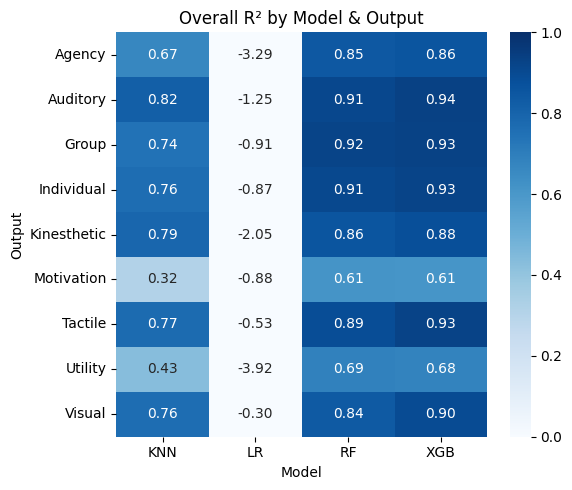

In [ ]:
pivot_over = df_overall.pivot(index='Output', columns='Model', values='R2')
plt.figure(figsize=(6,5))
sns.heatmap(pivot_over, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1)
plt.title("Overall R² by Model & Output")
plt.tight_layout()
plt.show()